# Zeitreihenmodell
Entwicklung eines Zeitreihenmodells zur Vorhersage verfügbarer Parkplätze in hamburger Parkhäusern.

## Idee
Das Modell sagt die Anzahl verfügbarer Parkplätze in einem ausgewählten Parkhaus vorher.

## 1. Daten einlesen

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROTE_BEETE: int = 0

DATA_PATH: str = "../data/data.csv"
COLUMN_INDEX_END_ALSTERHAUS: int = 12 # letzte Spalte mit Daten zum Parkhaus "Alsterhaus"
COLUMN_INDEX_BEGIN_WEATHER: int = 539 # erste Spalte mit Wetterdaten

df: pd.DataFrame = pd.read_csv(DATA_PATH)

print(df.columns)

print(f"Anzahl Merkmale: {len(df.columns)}")
print(f"Anzahl Beobachtungen: {len(df.index)}")

Index(['timestamp', 'Unnamed: 0', 'Alsterhaus_art', 'Alsterhaus_auslastung',
       'Alsterhaus_behindertenst', 'Alsterhaus_frauenst', 'Alsterhaus_frei',
       'Alsterhaus_gesamt', 'Alsterhaus_lat', 'Alsterhaus_lon',
       ...
       'humidity', 'precip_dur', 'precip_ind', 'precip', 'sunshine', 'temp',
       'temp_min', 'temp_max', 'soiltemp', 'dewpoint'],
      dtype='object', length=558)
Anzahl Merkmale: 558
Anzahl Beobachtungen: 4419


## 2. Daten vorverarbeiten
- nur Daten für ein Parkhaus beibehalten -> alle Parkhausspalten außer "Alsterhaus" entfernen

In [3]:
# nicht benötigte Spalten entfernen
df = df.drop(df.iloc[:, COLUMN_INDEX_END_ALSTERHAUS+1:COLUMN_INDEX_BEGIN_WEATHER], axis=1)

# Indizes der Zeilen mit NaN heraussuchen
indexes_to_delete: list = []
for i in range(0, len(df.index)):
    if math.isnan(df["temp"].iloc[i]): indexes_to_delete.append(i)
# Zeilen mit NaN entfernen
df = df.drop(indexes_to_delete, axis=0)

print(f"Anzahl Merkmale: {len(df.columns)}")
print(f"Anzahl Beobachtungen: {len(df.index)}")

Anzahl Merkmale: 32
Anzahl Beobachtungen: 4406


- Parkhausdaten in Zeitreihen umwandeln
    - erstmal nur Spalte "Alsterhaus_frei"
    - vorhergesagter Wert: nächster Wert nach dem Fenster

In [4]:
from datetime import datetime

print(f"Anzahl Spalten: {len(df.columns)}\nAnzahl Zeilen: {len(df.index)}")
print(df.describe().transpose())

#df["Alsterhaus_frei"].plot()

# Daten in Zeitreihen umwandeln
WINDOW_LENGTH: int = 18
WINDOW_OVERLAP: float = .9
PREDICTED_VALUE_OFFSET: int = 1
FEATURES: int = 13

def get_features_2_append_2_timeseries(df: pd.DataFrame, i: int, onehot=False) -> list:
    temp: list = []

    weekday = datetime.strptime(df["timestamp"].iloc[i], "%Y-%m-%d %H:%M:%S").weekday()

    temp.append(df["Alsterhaus_frei"].iloc[i])
    temp.append(df["temp"].iloc[i])
    temp.append(df["sunshine"].iloc[i])
    temp.append(df["wind_speed"].iloc[i])
    temp.append(df["wind_gust"].iloc[i]) # Windböhen
    temp.append(df["precip"].iloc[i]) # Niederschlag
    # Uhrzeit wäre vielleicht noch toll
    if onehot: # One-Hot-Encoding für Wochentage, damit manche Wochentage nicht als besser gewertet werden
        temp.append(1 if weekday == 0 else 0)
        temp.append(1 if weekday == 1 else 0)
        temp.append(1 if weekday == 2 else 0)
        temp.append(1 if weekday == 3 else 0)
        temp.append(1 if weekday == 4 else 0)
        temp.append(1 if weekday == 5 else 0)
        temp.append(1 if weekday == 6 else 0)
    else:
        temp.append(weekday)

    return temp

i: int = 0
weekday: int = 0
X = []
y = []
while (i + WINDOW_LENGTH + PREDICTED_VALUE_OFFSET) < len(df.index):
    temp: list = []
    # Anzahl freier Parkplätze aus 48 aufeinanderfolgenden Zeilen in eine Zeile von X schreiben
    for j in range(i, i+WINDOW_LENGTH):
        weekday = datetime.strptime(df["timestamp"].iloc[j], "%Y-%m-%d %H:%M:%S").weekday()
        temp.append(get_features_2_append_2_timeseries(df, j, onehot=True))
    X.append(temp)
    # vorherzusagenden Wert zu y hinzufügen (Wert 1/2 Stunde nach dem letzten Wert in X)
    y.append(df["Alsterhaus_frei"].iloc[i + WINDOW_LENGTH + PREDICTED_VALUE_OFFSET])

    i += int(WINDOW_LENGTH * (1 - WINDOW_OVERLAP))

X = np.array(X)
y = np.array(y)

print(f"\nAnzahl Zeitreihen: {len(y)}")

Anzahl Spalten: 32
Anzahl Zeilen: 4406
                           count         mean           std          min  \
Alsterhaus_auslastung     4406.0    33.456650  2.917550e+01     3.000000   
Alsterhaus_behindertenst  4406.0     3.000000  0.000000e+00     3.000000   
Alsterhaus_frauenst       4406.0     6.000000  0.000000e+00     6.000000   
Alsterhaus_frei           4406.0    57.923059  2.538365e+01     0.000000   
Alsterhaus_gesamt         4406.0    86.842034  3.704219e+00     0.000000   
Alsterhaus_lat            4406.0    53.552669  0.000000e+00    53.552669   
Alsterhaus_lon            4406.0     9.991765  1.776558e-15     9.991765   
wind_dir                  4406.0   231.340841  9.175117e+01    10.000000   
wind_speed                4406.0     3.990470  1.911733e+00     0.200000   
wind_speed_min            4406.0     2.449814  1.374908e+00     0.000000   
wind_speed_max            4406.0     4.359887  2.034553e+00     0.200000   
wind_gust                 4406.0     6.141713  2.

- Aufteilen in Trainings-, Validierungs- und Testdaten, Verhältnis 60:20:20

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6, random_state=ROTE_BEETE)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=.5, random_state=ROTE_BEETE)

print(f"Datensätze in Trainingsdaten: {len(y_train)}\nDatensätze in Validierungsdaten: {len(y_val)}\nDatensätze in Testdaten: {len(y_test)}\n")

Datensätze in Trainingsdaten: 2632
Datensätze in Validierungsdaten: 877
Datensätze in Testdaten: 878



### Daten skalieren

In [6]:
from sklearn.preprocessing import StandardScaler

n_samples, _, _ = X_train.shape

X_train_2D = X_train.reshape(-1, FEATURES)

scaler_X = StandardScaler()
X_train_scaled_2D = scaler_X.fit_transform(X_train_2D)

X_train_scaled = X_train_scaled_2D.reshape(n_samples, WINDOW_LENGTH, FEATURES)

n_samples, _, _ = X_val.shape
X_val_2D = X_val.reshape(-1, FEATURES)
X_val_scaled = scaler_X.transform(X_val_2D).reshape(n_samples, WINDOW_LENGTH, FEATURES)

n_samples, _, _ = X_test.shape
X_test_2D = X_test.reshape(-1, FEATURES)
X_test_scaled = scaler_X.transform(X_test_2D).reshape(n_samples, WINDOW_LENGTH, FEATURES)

scaler_y = StandardScaler()
X_train_1st_col_2D = X_train[:,:,0].reshape(-1, 1)
scaler_y.fit(X_train_1st_col_2D)

y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

## 3. Modell trainieren
Erkenntnisse:
- Flatten > GlobalAveragePooling1D als Übergang CNN->FCNN
- mehr Schichten machens nicht wirklich besser

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input # type: ignore

model = tf.keras.models.Sequential([
    Input((WINDOW_LENGTH, FEATURES)),
    Conv1D(filters=128, kernel_size=3, activation="relu"),
    MaxPooling1D(2),
    Conv1D(filters=256, kernel_size=3, activation="relu"),
    Flatten(),
    Dropout(.01),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dropout(.01),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

2025-06-05 21:05:33.744410: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 21:05:34.007997: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 21:05:34.315005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749150334.468776  123365 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749150334.497969  123365 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749150334.611667  123365 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 16, 128)        │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,169 (4.06 MB)

 Trainable params: 1,063,169 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=2)

print(f"RMSE: {model.evaluate(X_val_scaled, y_val_scaled)[1]}")

Epoch 1/50
83/83 - 3s - 30ms/step - loss: 0.1586 - root_mean_squared_error: 0.3982
Epoch 2/50
83/83 - 1s - 8ms/step - loss: 0.0710 - root_mean_squared_error: 0.2664
Epoch 3/50
83/83 - 1s - 8ms/step - loss: 0.0412 - root_mean_squared_error: 0.2030
Epoch 4/50
83/83 - 1s - 8ms/step - loss: 0.0384 - root_mean_squared_error: 0.1960
Epoch 5/50
83/83 - 1s - 8ms/step - loss: 0.0321 - root_mean_squared_error: 0.1792
Epoch 6/50
83/83 - 1s - 8ms/step - loss: 0.0354 - root_mean_squared_error: 0.1880
Epoch 7/50
83/83 - 1s - 8ms/step - loss: 0.0271 - root_mean_squared_error: 0.1648
Epoch 8/50
83/83 - 1s - 8ms/step - loss: 0.0291 - root_mean_squared_error: 0.1706
Epoch 9/50
83/83 - 1s - 10ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633
Epoch 10/50
83/83 - 1s - 9ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715
Epoch 11/50
83/83 - 1s - 9ms/step - loss: 0.0289 - root_mean_squared_error: 0.1699
Epoch 12/50
83/83 - 1s - 9ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
Epoch 13/50

## 4. Auswertung

In [9]:
y_pred_scaled = model.predict(X_val_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mae: float = 0
mse: float = 0
rmse: float = 0
mae_rel: float = 0

for i in range(0, len(y_val)):
    diff: float = abs(y_val[i] - y_pred[i])[0]
    mae += diff
    mse += diff**2
    # Division durch 0 abfangen, wenn keine Parkplätze frei waren (y_val = 0)
    if y_val[i] != 0:
        mae_rel += diff / y_val[i]
    else:
        # kein Plan was man jetzt hier addieren soll, ich nehme einfach mal diff so wies ist
        mae_rel += diff

    print(f"real: {y_val[i]}, predicted: {y_pred[i]}, diff: {diff}, relative error: {(diff / y_val[i]) if y_val[i] != 0 else "undefined"}")

mae = mae / len(y_pred)
mse = mse / len(y_pred)
rmse = math.sqrt(mse)
mae_rel = mae_rel / len(y_pred)
print(f"\n-- Metriken --\nMAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nMAE(relative): {mae_rel}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
real: 47.0, predicted: [49.42009], diff: 2.4200897216796875, relative error: 0.0514912706740359
real: 81.0, predicted: [81.10124], diff: 0.1012420654296875, relative error: 0.001249902042341821
real: 69.0, predicted: [69.82381], diff: 0.8238067626953125, relative error: 0.011939228444859602
real: 83.0, predicted: [85.361], diff: 2.3610000610351562, relative error: 0.02844578386789345
real: 68.0, predicted: [69.52811], diff: 1.528106689453125, relative error: 0.022472157197840074
real: 70.0, predicted: [68.0305], diff: 1.9694976806640625, relative error: 0.02813568115234375
real: 81.0, predicted: [83.00763], diff: 2.00762939453125, relative error: 0.024785548080632717
real: 39.0, predicted: [40.23672], diff: 1.2367210388183594, relative error: 0.03171079586713742
real: 69.0, predicted: [68.260086], diff: 0.7399139404296875, relative error: 0.010723390441009964
real: 7.0, predicted: [10.306325], diff: 3.3063249588012695, relative error: 0.4723321369

Ist-Werte vs. vorhergesagte Werte in Diagramm plotten

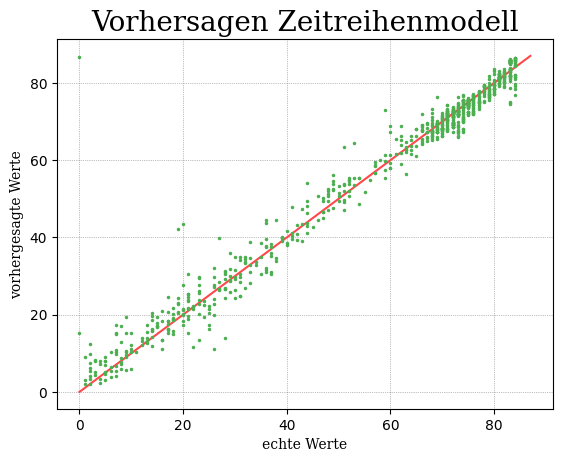

In [53]:
# Diagramm plotten
perfect_x: list = [0, 87]
perfect_y: list = [0, 87]
plt.plot(perfect_x, perfect_y, linestyle='-', color="#FF484B") # Linie für perfekte Vorhersage
plt.plot(y_val, y_pred, linestyle='', marker='.', ms=3, mec="#4CAF50", mfc="#4CAF50") # Vorhersagen des Modells

# Beschriftung hinzufügen
font1 = {'family':'serif','color':'black','size':20}
font2 = {'family':'serif','color':'black','size':10}
plt.title("Vorhersagen Zeitreihenmodell", fontdict=font1)
plt.xlabel("echte Werte", fontdict=font2)
plt.ylabel("vorhergesagte Werte", fontdict=font2)

plt.grid(color="#808080", linestyle=":", linewidth=.5)

plt.show()